# Neural Network with Entity Embeddings + SMOTENC

This notebook trains a neural network using entity embeddings for categorical features. This enables true entity embeddings that can learn semantic relationships between categorical values.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from sklearn.metrics import classification_report, accuracy_score, f1_score

from src.preprocessing_pipeline_with_embedding import build_preprocessed_data

2025-12-06 12:56:49.248090: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 12:56:49.297527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-06 12:56:49.297571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-06 12:56:49.300410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-06 12:56:49.316009: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Loading and preprocessing data (WITH SMOTENC + EMBEDDING format)...")
data = build_preprocessed_data(
    use_smote=True,
    smote_strategy='smotenc',
    impute_strategy='subgroup_mean',
    smote_minority_n=50_000,
    smote_majority_cap=100_000,
    output_format='embedding',
)

# Extract data
X_train_cat = data["X_train_cat"]
X_train_cont = data["X_train_cont"]
y_train = data["Y_train"].astype('int32')

X_val_cat = data["X_val_cat"]
X_val_cont = data["X_val_cont"]
y_val = data["Y_val"].astype('int32')

X_test_cat = data["X_test_cat"]
X_test_cont = data["X_test_cont"]
y_test = data["Y_test"].astype('int32')

# Metadata
categorical_info = data["categorical_info"]
cols_categorical = data["cols_categorical"]
cols_continuous = data["cols_continuous"]

print(f"\nCategorical features: {cols_categorical}")
print(f"Categorical shape: {X_train_cat.shape}")
print(f"Continuous shape: {X_train_cont.shape}")
print(f"\nEmbedding configuration:")
for col, info in categorical_info.items():
    print(f"  {col}: {info['num_categories']} categories -> {info['embed_dim']}D embedding")

Loading and preprocessing data (WITH SMOTENC + EMBEDDING format)...
[Memory] Pipeline start: 0.66 GB
Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.
[Memory] After data load: 28.03 GB
Loaded 2302521 rows

Pre-sampling for SMOTE (minority_n=50000, majority_cap=100000)...
Original class distribution:
FIRE_SIZE_LABEL
small         2241807
medium          55930
large            3682
very large       1102
Name: count, dtype: int64
  small: sampled 100000 from 2241807
  medium: sampled 50000 from 55930
  large: sampled 3682 from 3682
  very large: sampled 1102 from 1102
Total sampled: 154784 rows
[Memory] After sampling: 21.61 GB
Imputing with subgroup mean (GACC_PL)...

Applying SMOTENC on pre-sampled data...
[Memory] Before SMOTENC: 19.16 GB
SMOTENC input shape: (92870, 45)
Class distribution before SMOTE:
FIRE_SIZE_LABEL
0    59995
1    29993
2     2219
3      663
Name: count, dtype: int64
[Memory] Befo

In [3]:
def build_embedding_model(categorical_info, num_continuous, num_classes,
                           l2_reg=0.01, dropout_rate=0.5):
    """
    Build a neural network with embeddings for categorical features.

    Architecture:
    - Each categorical feature gets its own Embedding layer
    - Embeddings are flattened and concatenated
    - Continuous features are processed through dense layer
    - Both paths are concatenated for final classification

    Args:
        categorical_info: dict with {col_name: {'num_categories': int, 'embed_dim': int, 'col_idx': int}}
        num_continuous: number of continuous features
        num_classes: number of output classes
    """

    cat_inputs = []
    cat_embeddings = []

    # Sort by col_idx to maintain proper order
    sorted_cats = sorted(categorical_info.items(), key=lambda x: x[1]['col_idx'])
    for feat_name, config in sorted_cats:
        # Input for this categorical (single integer value)
        inp = layers.Input(shape=(1,), dtype='int32', name=f'input_{feat_name}')
        cat_inputs.append(inp)

        # Embedding layer
        # input_dim = num_categories + 1 for potential OOV values
        emb = layers.Embedding(
            input_dim=config['num_categories'] + 1,
            output_dim=config['embed_dim'],
            embeddings_regularizer=regularizers.l2(l2_reg),
            name=f'embed_{feat_name}'
        )(inp)

        # Flatten
        emb = layers.Flatten(name=f'flatten_{feat_name}')(emb)
        cat_embeddings.append(emb)

    continuous_input = layers.Input(shape=(num_continuous,), dtype='float32', name='input_continuous')

    # Small dense layer to process continuous features
    cont_processed = layers.Dense(
        32, activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg),
        name='continuous_dense')(continuous_input)
    cont_processed = layers.BatchNormalization(name='continuous_bn')(cont_processed)
    cont_processed = layers.Dropout(dropout_rate * 0.5, name='continuous_dropout')(cont_processed)

    if cat_embeddings:
        all_embeddings = layers.Concatenate(name='concat_embeddings')(cat_embeddings)
        x = layers.Concatenate(name='concat_all')([all_embeddings, cont_processed])
    else:
        x = cont_processed

    # Classification Head
    x = layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg),
        name='dense_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.Dropout(0.3, name='dropout_1')(x)

    x = layers.Dense(
        32,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg),
        name='dense_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.Dropout(0.2, name='dropout_2')(x)

    # Output
    output = layers.Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=regularizers.l2(l2_reg),
        name='output')(x)
    
    # Build model
    all_inputs = cat_inputs + [continuous_input]
    model = Model(inputs=all_inputs, outputs=output, name='EntityEmbeddingModel')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [4]:
# Build model
num_classes = len(np.unique(y_train))
num_continuous = X_train_cont.shape[1]

print(f"Number of continuous features: {num_continuous}")
print(f"Number of classes: {num_classes}")

model = build_embedding_model(
    categorical_info=categorical_info,
    num_continuous=num_continuous,
    num_classes=num_classes
)

model.summary()

Number of continuous features: 43
Number of classes: 4


2025-12-06 12:58:32.788971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-06 12:58:32.979707: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-06 12:58:32.979744: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-06 12:58:32.986536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-06 12:58:32.986599: I external/local_xla/xla/stream_executor

Model: "EntityEmbeddingModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_NWCG_CAUSE_CLASSIFIC  [(None, 1)]                  0         []                            
 ATION (InputLayer)                                                                               
                                                                                                  
 input_GACC_PL (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 input_continuous (InputLay  [(None, 43)]                 0         []                            
 er)                                                                                              
                                                                               

In [5]:
def prepare_model_inputs(X_cat, X_cont, categorical_info):
    """
    Prepare inputs for the multi-input embedding model.
    
    Returns a list: [cat_col_0, cat_col_1, ..., continuous_features]
    """
    inputs = []
    
    # Sort categorical columns by index to match model input order
    sorted_cats = sorted(categorical_info.items(), key=lambda x: x[1]['col_idx'])
    
    # Add each categorical column as separate input
    for feat_name, config in sorted_cats:
        col_idx = config['col_idx']
        inputs.append(X_cat[:, col_idx])
    
    # Add continuous features
    inputs.append(X_cont)
    
    return inputs

# Prepare inputs
train_inputs = prepare_model_inputs(X_train_cat, X_train_cont, categorical_info)
val_inputs = prepare_model_inputs(X_val_cat, X_val_cont, categorical_info)
test_inputs = prepare_model_inputs(X_test_cat, X_test_cont, categorical_info)

print(f"Number of model inputs: {len(train_inputs)}")
print(f"Input shapes: {[x.shape for x in train_inputs]}")

Number of model inputs: 3
Input shapes: [(239980,), (239980,), (239980, 43)]


In [6]:
# Train Model
print("Training Entity Embedding Neural Network...")

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=50,
    batch_size=2048,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training Entity Embedding Neural Network...
Epoch 1/50


2025-12-06 12:58:53.291689: I external/local_xla/xla/service/service.cc:168] XLA service 0x740199151ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-06 12:58:53.291729: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-12-06 12:58:53.296293: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-06 12:58:53.313811: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1765043933.362471   58388 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/118 [==============================] - 4s 15ms/step - loss: 2.3917 - accuracy: 0.4041 - val_loss: 1.8477 - val_accuracy: 0.4657 - lr: 0.0010
Epoch 2/50
118/118 [==============================] - 2s 14ms/step - loss: 1.6187 - accuracy: 0.4787 - val_loss: 1.4553 - val_accuracy: 0.4100 - lr: 0.0010
Epoch 3/50
118/118 [==============================] - 2s 14ms/step - loss: 1.2689 - accuracy: 0.5152 - val_loss: 1.3356 - val_accuracy: 0.3366 - lr: 0.0010
Epoch 4/50
118/118 [==============================] - 2s 14ms/step - loss: 1.1035 - accuracy: 0.5369 - val_loss: 1.2749 - val_accuracy: 0.3182 - lr: 0.0010
Epoch 5/50
118/118 [==============================] - 2s 14ms/step - loss: 1.0226 - accuracy: 0.5581 - val_loss: 1.2096 - val_accuracy: 0.3483 - lr: 0.0010
Epoch 6/50
118/118 [==============================] - 1s 12ms/step - loss: 0.9812 - accuracy: 0.5747 - val_loss: 1.1037 - val_accuracy: 0.4501 - lr: 0.0010
Epoch 7/50
118/118 [==============================] - 2s 13ms/step - loss: 

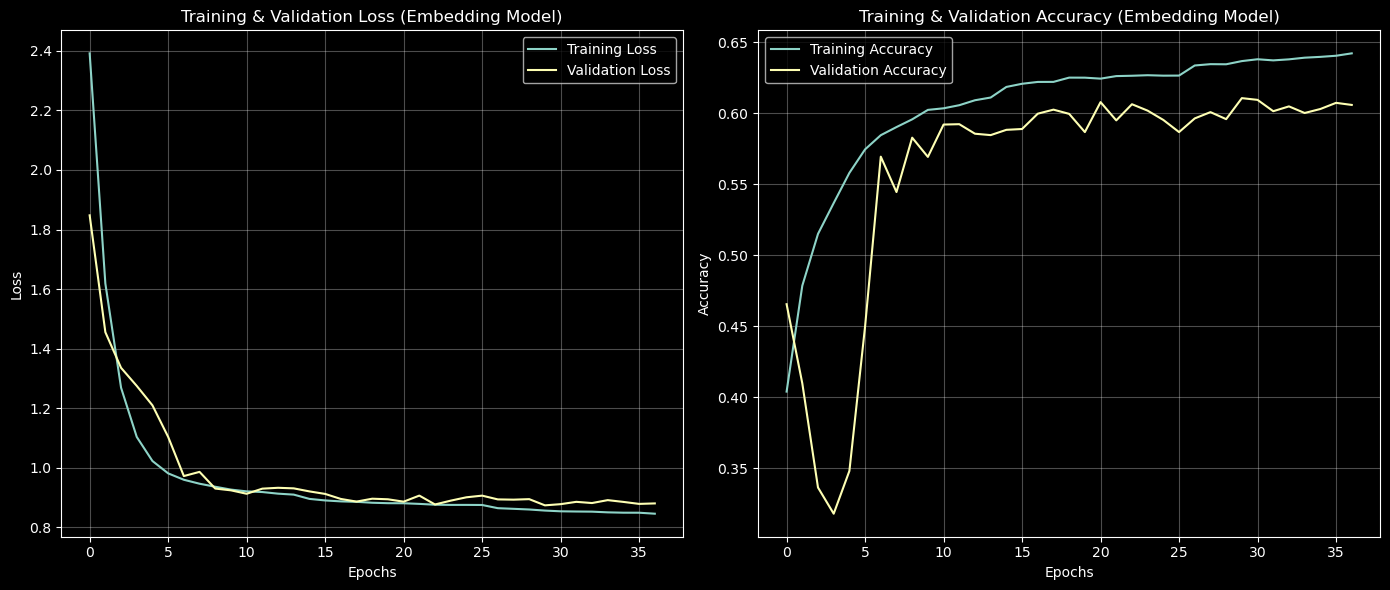

In [7]:
plt.style.use('dark_background')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left Plot: Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training & Validation Loss (Embedding Model)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right Plot: Accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training & Validation Accuracy (Embedding Model)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Evaluate on Validation Set
print("Evaluating on Validation Set...")
y_pred_val_prob = model.predict(val_inputs)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print(f"Validation Macro F1: {f1_score(y_val, y_pred_val, average='macro'):.4f}")
print("\nClassification Report (Validation):\n")
print(classification_report(y_val, y_pred_val))

Evaluating on Validation Set...
968/968 [==============================] - 3s 3ms/step
Validation Accuracy: 0.6108
Validation Macro F1: 0.3749

Classification Report (Validation):

              precision    recall  f1-score   support

           0       0.80      0.72      0.76     20004
           1       0.49      0.40      0.44     10004
           2       0.08      0.41      0.14       729
           3       0.09      0.51      0.16       220

    accuracy                           0.61     30957
   macro avg       0.37      0.51      0.37     30957
weighted avg       0.68      0.61      0.64     30957

